In [1]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
from skimage.util import random_noise
import random

cv.setUseOptimized(True)
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

### The first step 

In [2]:
def get_search_window(height, width, k_hard, n_hard, window_center):
    x, y = window_center
    left_up_x = x + k_hard/2 - n_hard/2
    left_up_y = y + k_hard/2 - n_hard/2
    right_down_x = left_up_x + n_hard
    right_down_y = left_up_y + n_hard

    # prevent search window from out of image range
    if left_up_x < 0:
        left_up_x = 0
    elif right_down_x > height:
        left_up_x = height - n_hard
    if left_up_y < 0:
        left_up_y = 0
    elif right_down_y > width:
        left_up_y = width - n_hard

    return int(left_up_x), int(left_up_y) # return window coordinate

In [3]:
def check_boundary(i, j, height, width, k_hard):
    if i + k_hard > height:
        i = height - k_hard
    if j + k_hard > width:
        j = width - k_hard
    return i, j

In [4]:
def get_kaiser_window(k_hard):
    window = np.kaiser(k_hard, 2.) # kaiser window with shape alpha=2.0 in the paper
    window_2d = window[:, np.newaxis] @ window[np.newaxis, :]
    return window_2d

We have $d(P,Q) \leq \tau_{hard}$ and $d(P,Q)=\frac{{\Vert \gamma^{\prime}(P)-\gamma^{\prime}(Q)\Vert}^2_2}{(k^{hard})^2} $, so the threshold is defined as ${\Vert \gamma^{\prime}(P)-\gamma^{\prime}(Q)\Vert}_2 \leq \sqrt{\tau_{hard}*(k^{hard})^2}$ for 2D version.

In [5]:
def get_similar_patches(img, window_center, k_hard, N_hard, n_hard, p_hard, tau_hard):
    x, y = window_center
    img = img.astype(np.float64)
    height, width = img.shape
    height -= k_hard
    width -= k_hard
    patch = img[x:x+k_hard, y:y+k_hard]
    # h, w = patch.shape
    #print(patch.shape)
    # solve cv.dct error "Odd-size DCT's are not implemented in function 'apply'"
    # if h != w:
    #     k_hard = min(h,w)
    # if h%2 == 1:
    #     k_hard = h - 1
    # if w%2 == 1:
    #     k_hard = w - 1
    
    threshold = np.sqrt(tau_hard) * k_hard
    patch = img[x:x+k_hard, y:y+k_hard]
    patch_dct = cv.dct(patch) # discrete Cosine transform of 2D array
    patch_num = int((n_hard - k_hard) / p_hard)
    window_x, window_y = get_search_window(height, width, k_hard, n_hard, window_center)
    similar_pats_dct = np.zeros([patch_num*patch_num, k_hard, k_hard], dtype=float)
    similar_pats_pos = np.zeros([patch_num*patch_num,2], dtype=int)
    patch_dis = np.zeros(patch_num*patch_num)

    similar_index = 0
    for i in range(patch_num):
        for j in range(patch_num):
            x = window_x + i*p_hard
            y = window_y + j*p_hard
            patch_tmp = img[x:x+k_hard, y:y+k_hard]
            patch_tmp_dct = cv.dct(patch_tmp)
            distance = np.linalg.norm(patch_dct - patch_tmp_dct)
            
            # threshold filtering
            if distance < threshold:
                similar_pats_dct[similar_index, :, :] = patch_tmp_dct
                similar_pats_pos[similar_index, :] = x, y
                patch_dis[similar_index] = distance
                similar_index += 1

    # check the best N_hard similar patches and cv.dct odd again
    if similar_index > N_hard:
        similar_index = N_hard
    if similar_index%2 == 1:
        similar_index = similar_index - 1
    if similar_index == 0:
        similar_index = 2

    similar_pat_best = np.zeros([similar_index, k_hard, k_hard], dtype=float)
    similar_pat_best[0, :, :] = patch_dct
    pat_best_pos = np.zeros([similar_index, 2], dtype=int)
    pat_best_pos[0, :] = window_center
    sorted_dis = patch_dis[:similar_index].argsort()

    for i in range(1, similar_index):
        similar_pat_best[i, :, :] = similar_pats_dct[sorted_dis[i-1], :, :]
        pat_best_pos[i, :] = similar_pats_pos[sorted_dis[i-1], :]

    return similar_pat_best, pat_best_pos, similar_index+1

In [6]:
def filtering_3D(similar_pat_dct, threshold):
    nonzero_num = 0
    shape = similar_pat_dct.shape
    for i in range(shape[1]):
        for j in range(shape[2]):
            pixel_relative = similar_pat_dct[:, i, j]
            pixel_dct = cv.dct(pixel_relative)
            pos = np.where(np.abs(pixel_dct) < threshold)
            pixel_dct[pos] = 0
            nonzero_num += pixel_dct.nonzero()[0].size
            similar_pat_dct[:, i, j] = cv.idct(pixel_dct)[0]

    return similar_pat_dct, nonzero_num

In [7]:
def aggregation(patches_dct, patches_pos, nonzero_num, img_basic, weight_basic, kasier):
    shape = patches_dct.shape
    if nonzero_num < 1:
        nonzero_num = 1

    w = kasier / nonzero_num
    for i in range(shape[0]):
        x, y = patches_pos[i, :]
        patches_idct = w * cv.idct(patches_dct[i, :, :])
        img_basic[x:x+shape[1], y:y+shape[2]] += patches_idct 
        weight_basic[x:x+shape[1], y:y+shape[2]] += w


In [8]:
def bm3d_first_step(img_noisy, sigma, k_hard, n_hard, p_hard, N_hard, tau_hard, lambda_hard_3D):
    height, width = img_noisy.shape

    # initialize arrays to store image after basic filtering
    img_basic = np.zeros((height+k_hard, width+k_hard))
    weight_basic = np.zeros((height+k_hard, width+k_hard))

     # limit boundary will make odd dimensions or size dismatch
    img_noisy = np.hstack((img_noisy, np.zeros((height,k_hard))))
    img_noisy = np.vstack((img_noisy, np.zeros((k_hard,width+k_hard))))

    # construct Kaiser window
    kaiser_window = get_kaiser_window(k_hard)
  
    for i in range(0, height, p_hard):
        for j in range(0, width, p_hard):
            # prevent search window center from out of range
            x, y = check_boundary(i, j, height, width, k_hard)          

            # search for N_hard best similar patches
            similar_pat_dct, similar_pat_pos, index = get_similar_patches(img_noisy, [i,j], k_hard, N_hard, n_hard, p_hard, tau_hard)

            # do collaborative Filtering
            similar_pat_dct, nonzero_num = filtering_3D(similar_pat_dct, lambda_hard_3D*sigma)

            # aggregation (note that arrays will be changed after calling functions in python)
            aggregation(similar_pat_dct, similar_pat_pos, nonzero_num, img_basic, weight_basic, kaiser_window)

    img_basic = img_basic / weight_basic  
    img_basic = img_basic[:height, :width]
    img_noisy = img_noisy[:height, :width]
    #print(img_noisy.shape)
    cv.imwrite("bm3d_basic_gray.jpg", img_basic)
    return img_basic   
 

### The second step

In [9]:
def patch_matching_again(img_basic, img_noisy, window_center, k_wien, N_wien, n_wien, p_wien, tau_wien):
    x, y = window_center
    img_basic = img_basic.astype(np.float64)
    img_noisy = img_noisy.astype(np.float64)
    height, width = img_basic.shape 
    height -= k_hard
    width -= k_hard
    threshold = np.sqrt(tau_wien) * k_wien

    # DCT transform for image processed in the first step
    basic_patch = img_basic[x:x+k_wien, y:y+k_wien]
    basic_patch_dct = cv.dct(basic_patch)

    # DCT transform for original noisy image 
    noisy_patch = img_noisy[x:x+k_wien, y:y+k_wien]
    noisy_patch_dct = cv.dct(noisy_patch)

    # compute search window and initialize final similar patches
    patch_num = int((n_wien - k_wien) / p_wien)
    window_x, window_y = get_search_window(height, width, k_wien, n_wien, window_center)
    similar_pats_dct = np.zeros([patch_num*patch_num, k_wien, k_wien], dtype=float)
    similar_pats_pos = np.zeros([patch_num*patch_num, 2], dtype=int)
    patch_dis = np.zeros(patch_num*patch_num)

    patch_index = 0
    # new threshold filtering
    for i in range(patch_num):
        for j in range(patch_num):
            x = window_x + i*p_wien
            y = window_y + j*p_wien
            patch_tmp = img_basic[x:x+k_wien, y:y+k_wien]
            patch_tmp_dct = cv.dct(patch_tmp)
            distance = np.linalg.norm(basic_patch_dct - patch_tmp_dct)

            if distance < threshold:
                similar_pats_dct[patch_index, :, :] = patch_tmp_dct
                similar_pats_pos[patch_index, :] = x, y
                patch_dis[patch_index] = distance
                patch_index += 1

    if patch_index > N_hard:
        patch_index = N_hard
    if (patch_index % 2) == 1:
        patch_index = patch_index - 1
    if patch_index == 0:
        patch_index = 2

    similar_pat_final_dct = np.zeros([patch_index, k_wien, k_wien], dtype=float)
    similar_pat_final_dct[0, :, :] = basic_patch_dct
    noisy_pat_final = np.zeros([patch_index, k_wien, k_wien], dtype=float)
    noisy_pat_final[0, :, :] = noisy_patch_dct
    pat_final_pos = np.zeros([patch_index, 2], dtype=int)
    pat_final_pos[0, :] = window_center
    sort = patch_dis.argsort()
    
    for i in range(1, patch_index):
        similar_pat_final_dct[i, :, :] = similar_pats_dct[sort[i-1], :, :]
        x, y = similar_pats_pos[sort[i-1], :]
        noisy_pat_final[i, :, :] = cv.dct(img_noisy[x:x+k_wien, y:y+k_wien])
        pat_final_pos[i, :] = similar_pats_pos[sort[i-1], :]

    return similar_pat_final_dct, noisy_pat_final, pat_final_pos, patch_index+1          

In [10]:
def wiener_filtering(similar_pat_dct, noisy_pat_dct, sigma):
    shape = similar_pat_dct.shape
    wiener_weight = np.zeros((shape[1], shape[2]), dtype=float)

    for i in range(shape[1]):
        for j in range(shape[2]):
            pixel = similar_pat_dct[:, i, j]
            pixel = np.matrix(pixel)
            norm = np.float64(pixel*pixel.T)
            w = norm / (norm + sigma*sigma)

            if w != 0:
                wiener_weight[i, j] = 1. / (w*w)

            similar_pat_dct[:, i, j] = w * noisy_pat_dct[:, i, j]

    return similar_pat_dct, wiener_weight

In [11]:
def wiener_aggregation(similar_pat_dct, wiener_weight, patch_pos, img_basic, weight_basic):
    shape = similar_pat_dct.shape

    for i in range(shape[0]):
        x, y = patch_pos[i, :]
        patch_idct = wiener_weight * cv.idct(similar_pat_dct[i, :, :])
        img_basic[x:x+shape[1], y:y+shape[2]] += patch_idct
        weight_basic[x:x+shape[1], y:y+shape[2]] += wiener_weight


In [12]:
def bm3d_second_step(img_basic, img_noisy, sigma, k_wien, n_wien, N_wien, p_wien, tau_wien):
    height, width = img_basic.shape
    #print(img_noisy.shape)
    # initialize arrays to store image after basic filtering
    img_final = np.zeros((height+k_wien, width+k_wien))
    weight_final = np.zeros((height+k_wien, width+k_wien))

    #print(height, width)
     # limit boundary will make odd dimensions or size dismatch
    img_basic = np.hstack((img_basic, np.zeros((height,k_wien))))
    img_basic = np.vstack((img_basic, np.zeros((k_wien,width+k_wien))))
    img_noisy = np.hstack((img_noisy, np.zeros((height,k_wien))))
    img_noisy = np.vstack((img_noisy, np.zeros((k_wien,width+k_wien))))

    kaiser = get_kaiser_window(k_wien)

    # similar steps with the first step
    for i in range(0, height, p_wien):
        for j in range(0, width, p_wien):
            # prevent search window center from out of range
            x, y = check_boundary(i, j, height, width, k_wien)          

            # follow 3 parts of second step
            patch_dct, patch_noisy_dct, patch_pos, index = patch_matching_again(img_basic, img_noisy, [i,j], k_wien, N_wien, n_wien, p_wien, tau_wien)
            patch_dct, wiener_weight = wiener_filtering(patch_dct, patch_noisy_dct, sigma)
            wiener_aggregation(patch_dct, wiener_weight, patch_pos, img_final, weight_final)

    img_final = img_final / weight_final
    img_final = img_final[:height, :width]

    cv.imwrite("bm3d_denoised_gray.jpg", img_final)
    return img_final

In [13]:
def sp_noise(image,prob=0.02):
    output = np.zeros(image.shape,np.uint8)
    thres = 1 - prob/2

    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            rdn = random.random()
            if rdn < prob/2:
                output[i][j] = 0
            elif rdn > thres:
                output[i][j] = 255
            else:
                output[i][j] = image[i][j]

    return output


In [14]:
def gasuss_noise(image, mean, sigma):
    image = np.array(image, dtype=float)
    noise = np.random.normal(mean, sigma, image.shape)
    out = image + noise
    out = out/255
    
    out = np.clip(out, 0, 1.0)
    out = np.uint8(out*255)

    return out

In [15]:
image = cv.imread("test.jpg", cv.IMREAD_GRAYSCALE)
sigma = 40
k_hard = 8
n_hard = 39
p_hard = 3 
N_hard = 16
tau_hard = 5000 
lambda_hard_3D = 2.7

k_wien = 8 
n_wien = 39
N_wien = 32
p_wien = 3 
tau_wien = 3500
random.seed(42)
image_noisy_sp = sp_noise(image,0.5)
image_gaussion = gasuss_noise(image, 0, sigma)
cv.imwrite("test_gaussion_gray.jpg", image_gaussion)
image_basic = bm3d_first_step(image_noisy_sp, sigma, k_hard, n_hard, p_hard, N_hard, tau_hard, lambda_hard_3D)
image_denoised = bm3d_second_step(image_basic, image, sigma, k_wien, n_wien, N_wien, p_wien, tau_wien)

The larger the PSNR, the better the denoising.

In [16]:
def psnr(img_origin, img_denoised):
    img_origin = img_origin.astype(np.float64)
    img_denoised = img_denoised.astype(np.float64)
    rmse = np.sqrt(np.mean((img_origin - img_denoised)**2))
    if rmse == 0:
        print("Same image!")
    else:
        return 20 * np.log10(255. / rmse)

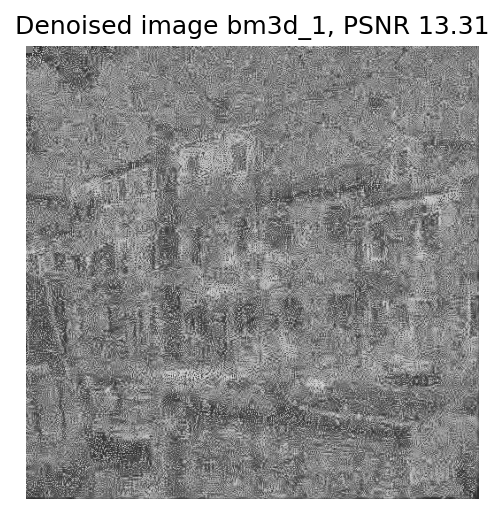

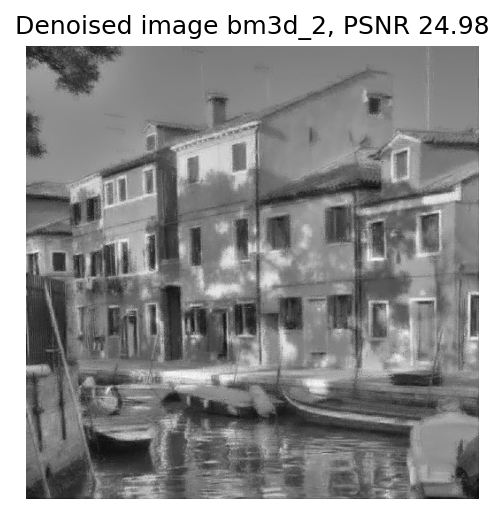

In [17]:
fig = plt.figure(dpi=150)
plt.imshow(image_basic, cmap='gray')
plt.axis('off')
plt.title(f'Denoised image bm3d_1, PSNR {psnr(image, image_basic):.2f}')
plt.show()
fig = plt.figure(dpi=150)
plt.imshow(image_denoised, cmap='gray')
plt.axis('off')
plt.title(f'Denoised image bm3d_2, PSNR {psnr(image, image_denoised):.2f}')
plt.show()